In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde

In [11]:
%%time
N=1024
var_J=1

@njit
def initial_lattice(N):
    M=np.ones((N))
    l=np.array([1,-1])
    for i in range(N):
            M[i]=np.random.choice(l)
    return(M)

@njit
def intraction(N,mean_J,var_J):
    J_matrix=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i<j :
                J_matrix[i][j]=random.gauss(mean_J/N,var_J/np.sqrt(N))
            else :
                J_matrix[i][j]=0
    J_matrix=J_matrix+np.transpose(J_matrix)  
    return(J_matrix)

@njit
def energy_local(M,J_matrix,i):
    H=np.sum(-J_matrix[i]*M[i]*M)
    return(H)

@njit
def energy_total(M,J_matrix,N):
    E_t=0
    for i in range(N):
        E_t=E_t+energy_local(M,J_matrix,i)
    E_t=E_t/2
    return(E_t)


@njit
def trial(J_matrix,N,T): 
    field_list=np.zeros(N)
    M=initial_lattice(N)
    E_t=energy_total(M,J_matrix,N)
    for trial in range(int(np.sqrt(N**3))):
        random_i=random.randrange(N)                
        M[random_i]=M[random_i]*(-1)
        delta_E=2*energy_local(M,J_matrix,random_i)
        if delta_E>0:
            p=np.exp(-delta_E/T)
            coin=random.random()
            if coin>p :
                M[random_i]=M[random_i]*(-1)
            else :
                E_t=E_t+delta_E
        else :
            E_t=E_t+delta_E
    
    for i in range(N):
        field=np.sum(-J_matrix[i]*M)
        field_list[i]=field

    return(field_list)


l_feature=[]
for mean_J in np.arange(0.000001,3,0.1):
    for T in np.arange(0.000001,3,0.1):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        if mean_J<var_J:
            l.append(abs(np.mean(field_time_series)))
            l.append(np.var(field_time_series))
            l_feature.append(l)
        elif mean_J>var_J:
            l.append(abs(np.mean(field_time_series))/mean_J)
            l.append(np.var(field_time_series))
            l_feature.append(l)

Wall time: 1min 15s


(300, 300)


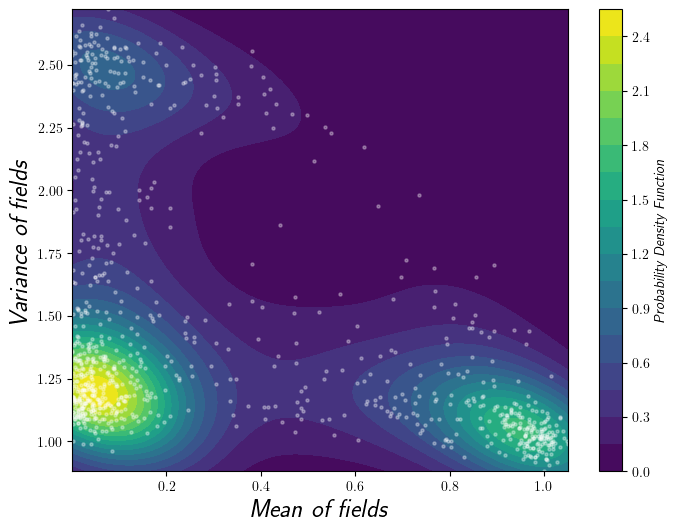

In [31]:
x=np.transpose(l_feature)[0]
y=np.transpose(l_feature)[1]
data = np.vstack([x, y])

kde = gaussian_kde(data)
pdf_values = kde(data)
pdf_2d = pdf_values.reshape(30, 30)

total_grid_number=300
x_grid = np.linspace(x.min(), x.max(), total_grid_number)
y_grid = np.linspace(y.min(), y.max(), total_grid_number)
X, Y = np.meshgrid(x_grid, y_grid)

Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
print(np.shape(Z))
x_dense=[]
y_dense=[]
threshold=0.6
for i in range(900):
    if threshold < Z[int((x[i]-np.min(x))/(np.max(x)-np.min(x)+0.00001)*300)][int((y[i]-np.min(y))/(np.max(y)-np.min(y)+0.00001)*300)]:
        x_dense.append(x[i])
        y_dense.append(y[i])

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='\\textit{Probability Density Function}')
plt.scatter(x, y, s=5, color='white', alpha=0.3)
plt.xlabel('\\textit{Mean of fields}', fontsize=18)
plt.ylabel('\\textit{Variance of fields}', fontsize=18)
plt.savefig("PDF_preprocess1.png",dpi=500)
plt.show()

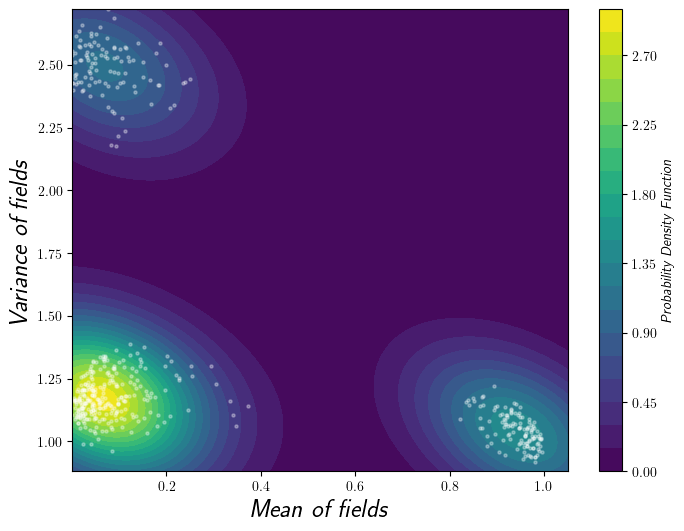

In [27]:
x_new=np.array(x_dense)
y_new=np.array(y_dense)
data = np.vstack([x_new, y_new])

kde = gaussian_kde(data)
pdf_values = kde(data)

total_grid_number=300
x_grid = np.linspace(x.min(), x.max(), total_grid_number)
y_grid = np.linspace(y.min(), y.max(), total_grid_number)
X, Y = np.meshgrid(x_grid, y_grid)

Z_new = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z_new, levels=20, cmap='viridis')
plt.colorbar(label='\\textit{Probability Density Function}')
plt.scatter(x_dense, y_dense, s=5, color='white', alpha=0.3)
plt.xlabel('\\textit{Mean of fields}', fontsize=18)
plt.ylabel('\\textit{Variance of fields}', fontsize=18)
plt.savefig("PDF_preprocess2.png",dpi=500)
plt.show()

In [28]:
l_feature_new=[x_dense, y_dense]
l_feature_new=np.transpose(l_feature_new)

X = np.array(l_feature_new)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

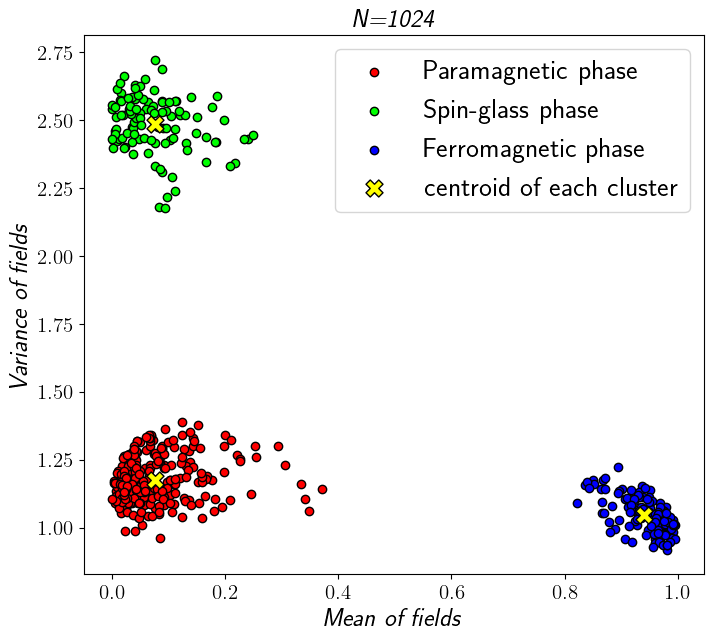

In [29]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,7))
colors = ['red','lime','blue']
l_label=['Paramagnetic phase','Spin-glass phase','Ferromagnetic phase','centroid of each cluster']
for i in range(3):
    cluster_points = X[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'{l_label[i]}',edgecolor='black',marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', c='yellow',label=f'{l_label[3]}',edgecolor='black' ,s=150)
plt.xlabel('\\textit{Mean of fields}', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('\\textit{Variance of fields}', fontsize=18)
plt.yticks(fontsize=15)
plt.title('\\textit{N=1024}', fontsize=18)
plt.legend(fontsize="20")
plt.savefig("K-means cluster_dual-revise",dpi=500)

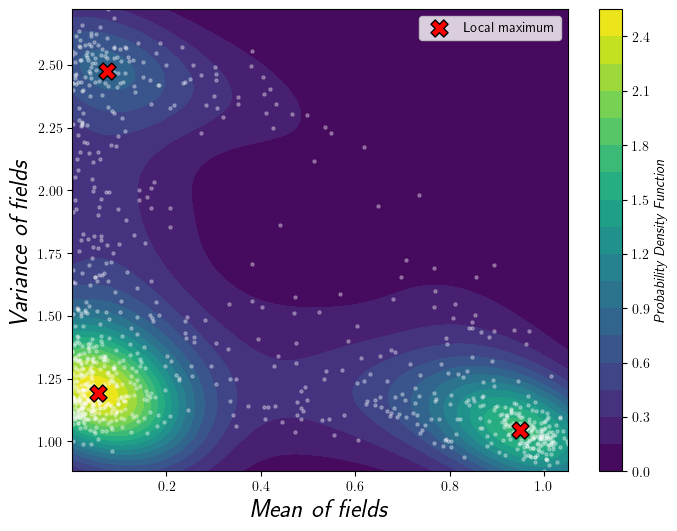

In [34]:
def find_local_maxima(matrix):
    rows, cols = matrix.shape
    local_maxima = []

    for i in range(1, rows - 1): 
        for j in range(1, cols - 1):
            current = matrix[i, j]
            neighbors = [
                matrix[i-1, j], matrix[i+1, j], 
                matrix[i, j-1], matrix[i, j+1], 
                matrix[i-1, j-1], matrix[i-1, j+1], 
                matrix[i+1, j-1], matrix[i+1, j+1] 
            ]

            if all(current > neighbor for neighbor in neighbors):
                local_maxima.append((i, j, current)) 

    return local_maxima

local_max = find_local_maxima(Z)
x_local_max=[]
y_local_max=[]
for i in range(len(local_max)):
    x_local_max.append(local_max[i][1])
    y_local_max.append(local_max[i][0])
x_local_max=np.array(x_local_max)
y_local_max=np.array(y_local_max)
x_local_max=x_local_max*(np.max(x)-np.min(x))/total_grid_number+np.min(x)
y_local_max=y_local_max*(np.max(y)-np.min(y))/total_grid_number+np.min(y)

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis', levels=20) 
plt.colorbar(label='\\textit{Probability Density Function}')
plt.scatter(x, y, s=5, color='white', alpha=0.3)
plt.scatter(x_local_max, y_local_max, marker='X', c='red',edgecolor='black',s=150, label="Local maximum")
plt.xlabel('\\textit{Mean of fields}', fontsize=18)
plt.ylabel('\\textit{Variance of fields}', fontsize=18)  
plt.legend()
plt.savefig("local_maximum2.png",dpi=500)
plt.show()